# supernode-edges

The procedure of constructing weighted P-space edges of the supernode network.

__Warning!__ Some procedures require 24 cores and up to 15 GB RAM.

Requires:
1. `data/preprocessed/routes.json`
2. `data/supernodes/supernodes.json`

Produces:
1. `data/supernodes/edges_pspace_alpha_metrics.json`
2. `data/supernodes/edges_pspace.json`

In [1]:
import sys
sys.path.append('..')

In [2]:
from typing import List, Dict
from multiprocessing import Pool
from collections import defaultdict

import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
from cartopy import crs as ccrs
from tqdm import tqdm
from scipy import sparse
from matplotlib import pyplot as plt

from myutils.networkx import get_layout
from myutils.spatial import get_earth_distances
from myutils.json import save_json, load_json
from myutils.matplotlib import matplotlib_latex, matplotlib_seaborn_style

from ptn.parallel_centralities import shortest_paths_parallel
from ptn.cartopy import add_map_subplot
from config import routes_fpath, supernodes_fpath, \
    edges_pspace_alpha_metrics_fpath, edges_pspace_fpath

matplotlib_seaborn_style()
matplotlib_latex()

In [3]:
routes = pd.read_json(routes_fpath).set_index('id')

routes.head(2)

,name,type,direction,stops,distance,supernodes
id,,,,,,
1125,А,tram,1,"[16396, 16367, 16371, 16398, 16400, 16401, 164...",5.008430,"[620, 827, 828, 20, 309, 80, 310, 204, 5, 29, ..."
11125,А,tram,2,"[33093, 16348, 16350, 16354, 16357, 16346, 163...",3.826103,"[30, 829, 830, 621, 311, 831, 14, 81, 620]"


In [4]:
supernodes = pd.read_json(supernodes_fpath).set_index('id')

supernodes.head(2)

,stops,diameter,types,lat,lon
id,,,,,
0,"[29058, 15366, 1687, 1688, 15385, 2080, 2081, ...",0.732963,"[bus, trolley, tram, subway]",59.85171,30.322415
1,"[18, 18077, 18078, 32036, 16177, 16050, 27063,...",0.909368,"[bus, tram, trolley, subway]",59.95021,30.287937


### L-space

### P-space

In [5]:
coords = supernodes[['lat', 'lon']].values
distances = get_earth_distances(coords, coords)


def get_route_distance(route: List[int]) -> float:
    return distances[route[:-1], route[1:]].sum()

In [6]:
def construct_pspace_graph() -> nx.Graph:
    edges = []

    for route_id, route in routes['supernodes'].iteritems():
        n = len(route)

        for i in range(n - 1):
            for j in range(i + 1, n):
                u = route[i]
                v = route[j]

                if u > v:
                    u, v = v, u

                subroute = route[i : j + 1]
                
                distance = get_route_distance(subroute)
                edges.append((u, v, distance, route_id))

    edges = pd.DataFrame(edges, columns=['u', 'v', 'distance', 'route_id'])\
        .sort_values(by=['u', 'v', 'distance']).drop_duplicates(['u', 'v'], keep='first')
    
    g = nx.Graph()
    g.add_nodes_from(supernodes.index)
    
    for _, row in edges.iterrows():
        u = int(row['u'])
        v = int(row['v'])
        distance = row['distance']
        route_id = int(row['route_id'])
        
        g.add_edge(u, v, hops=1, distance=distance, route=route_id)
    
    return g

In [7]:
pspace = construct_pspace_graph()

len(pspace), len(pspace.edges), nx.number_connected_components(pspace)

(3202, 118449, 3)

In [8]:
def assign_weights(g: nx.Graph, alpha: float) -> nx.Graph:
    g = g.copy()
    
    distances = pd.Series(nx.get_edge_attributes(g, 'distance'))
    weights = alpha * distances + 1 - alpha
    
    nx.set_edge_attributes(g, weights, 'weight')
    
    return g

In [9]:
edge_distances = nx.get_edge_attributes(pspace, 'distance')

type(edge_distances)

dict

In [10]:
def get_path_distance(path: list) -> float:
    if not isinstance(path, list):
        return np.nan
    
    return sum(
        edge_distances.get((u, v), edge_distances.get((v, u)))
        for u, v in zip(path, path[1:])
    )


def get_path_hops(path: list) -> float:
    if not isinstance(path, list):
        return np.nan
    
    else:
        return len(path) - 1

In [11]:
def get_lspace_path(pspace: nx.Graph, pspace_path: list) -> list:
    lspace_path = [pspace_path[0]]
    
    for u, v in zip(pspace_path, pspace_path[1:]):
        route_id = pspace[u][v]['route']
        route = routes.loc[route_id, 'supernodes']
        
        start = route.index(u)
        end = route.index(v)
        
        if start < end:
            route_part = route[start + 1:end + 1]
        else:
            route_part = route[start - 1:end:-1] + [route[end]]
        
        lspace_path.extend(route_part)
        
    return lspace_path

In [12]:
def build_lspace_path_graph(pspace_path: list) -> nx.Graph:
    lspace_path = get_lspace_path(pspace, pspace_path)
    
    g = nx.Graph()
    g.add_edges_from(zip(lspace_path, lspace_path[1:]))
    
    transfer = pd.Series(False, index=set(lspace_path))
    transfer[set(pspace_path)] = True
    
    nx.set_node_attributes(g, transfer, 'transfer')
    
    return g

In [13]:
pos = dict(zip(supernodes.index, supernodes[['lon', 'lat']].values))

In [14]:
mapes = pd.read_json(edges_pspace_alpha_metrics_fpath, encoding='utf-8')

mapes.head(2)

,alpha,hops_mape,distance_mape
0,0.000010,0.0,0.153925
1,0.012507,0.0,0.153925


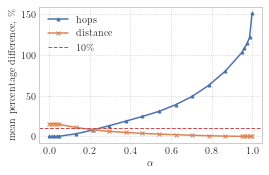

In [15]:
plt.figure(figsize=(4, 2.5))

plt.plot(mapes['alpha'], mapes['hops_mape'] * 100, label='hops', marker='^', markersize=3)
plt.plot(mapes['alpha'], mapes['distance_mape'] * 100, label='distance', marker='x', markersize=4)

plt.axhline(10, ls='dashed', lw=1, c='C3', label='$10\%$')

plt.xlabel('$\\alpha$')
plt.ylabel('mean percentage difference, $\%$')

plt.legend()

plt.savefig('../figures/weight_alpha_metrics.pdf', transparent=True, bbox_inches='tight')

In [16]:
pspace = assign_weights(pspace, alpha=0.2)

In [17]:
components = sorted(nx.connected_components(pspace.to_undirected()), key=len, reverse=True)

sizes = [0.5, 2, 2]
markers = ['o', 'v', 's']

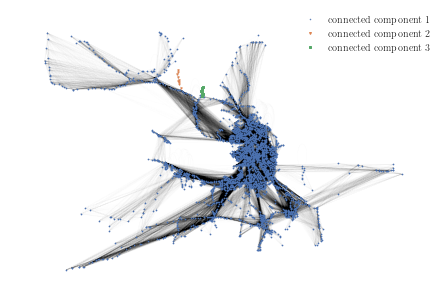

In [18]:
plt.figure(figsize=(6, 4))

handles = []
labels = []

for i, comp in enumerate(components):
    color = f'C{i}'
    marker = markers[i]
    size = sizes[i]
    
    nx.draw(pspace.subgraph(comp), pos, node_size=size, width=0.005, node_color=color, node_shape=marker)
    
    labels.append(f'connected component {i + 1}')
    handles.append(plt.Line2D([0], [0], color=color, linewidth=0, marker=marker, markersize=size))

plt.legend(handles=handles, labels=labels, loc='upper right')
    
plt.savefig('../figures/pspace_edges.png', dpi=250, transparent=True, bbox_inches='tight')

In [19]:
edges = []

for u, v in pspace.edges:
    item = pspace[u][v].copy()
    item['u'] = u
    item['v'] = v
    
    edges.append(item)
    
edges[:3]

[{'hops': 1,
  'distance': 23.271852922989886,
  'route': 10003,
  'weight': 5.454370584597977,
  'u': 0,
  'v': 6},
 {'hops': 1,
  'distance': 14.853275410680604,
  'route': 2871,
  'weight': 3.7706550821361207,
  'u': 0,
  'v': 8},
 {'hops': 1,
  'distance': 13.985378725185072,
  'route': 2871,
  'weight': 3.5970757450370145,
  'u': 0,
  'v': 9}]

In [20]:
save_json(edges, edges_pspace_fpath)

***

In [21]:
edges = load_json(edges_pspace_fpath)

edges[:2]

[{'hops': 1,
  'distance': 23.271852922989886,
  'route': 10003,
  'weight': 5.454370584597977,
  'u': 0,
  'v': 6},
 {'hops': 1,
  'distance': 14.853275410680604,
  'route': 2871,
  'weight': 3.7706550821361207,
  'u': 0,
  'v': 8}]

In [22]:
pspace = nx.Graph()

for edge in edges:
    pspace.add_edge(
        edge['u'],
        edge['v'],
        weight=edge['weight'],
        distance=edge['distance'],
        route=edge['route']
    )

len(pspace), len(pspace.edges)

(3202, 118449)

In [23]:
u = 286
v = 1177

shortest_path_hops = nx.shortest_path(pspace, u, v, weight=None)
shortest_path_distance = nx.shortest_path(pspace, u, v, weight='distance')

shortest_path_hops, shortest_path_distance

([286, 754, 1177], [286, 32, 269, 1177])

In [24]:
nodes = list(set(shortest_path_hops + shortest_path_distance))
node_coords = coords[nodes]

xmin, ymin = node_coords.min(axis=0) - 0.05
xmax, ymax = node_coords.max(axis=0) + 0.05

extent = [ymin, ymax, xmin, xmax]
scale = 13

extent

[30.038422133333334, 30.364942350000003, 59.6831599964135, 59.906372696723]

In [ ]:
fig = plt.figure(figsize=(6, 5))

ax = add_map_subplot(fig, 1, 1, 1, extent=extent, scale=scale)

Geometry must be a Point or LineString
